In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import OutputState, TriggerRearm, TriggerStart
from hardware import config as hcf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from logmodule import setup_logging
setup_logging()
import logging
logger = logging.getLogger(__name__)

In [3]:
hw = HardwareManager()
hw.add_default_hardware()

from measurement.task_base import JobManager

2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'uf' for Microfluidics Pnuematic Control added with address PneumaticControl 192.168.1.3:502
2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'camera' for Thorlabs Camera with address <hardware.camera.thorlabs.CameraController object at 0x000001D8A54A9B40>
2025-08-15 09:52:35 INFO windfreakcontrol ThreadPoolExecutor-0_1: Connected to Windfreak SynthHD on COM4
2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'windfreak' for Windfreak Synth with address <hardware.mw.windfreakcontrol.WindfreakSynth object at 0x000001D889933D30>
2025-08-15 09:52:35 INFO pulser ThreadPoolExecutor-0_4: Stream Sequence with 1 runs
2025-08-15 09:52:35 INFO pulser ThreadPoolExecutor-0_4: Reset Pulse Streamer
2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'pg' for Pulse Streamer with address <hardware.pulser.pulser.PulseGenerator object at 0x000001D8A54A8A60>


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'whitelight' for WhiteLight on channel /Dev1/ao0 with address <hardware.camera.light.WhiteLight object at 0x000001D8A54AA050>
2025-08-15 09:52:35 INFO hardwaremanager MainThread: Added 'pwr' for Mini-Circuits Power Meter with address <hardware.mw.detector.pwrcontrol.MWPowerMeter object at 0x000001D8A54A8070>
2025-08-15 09:52:36 INFO sidig ThreadPoolExecutor-0_5: Successfully connected to the digitizer
2025-08-15 09:52:36 INFO hardwaremanager MainThread: Added 'dig' for SI Digitizer with address <hardware.daq.sidig.FIFO_DataAcquisition object at 0x000001D8A54A8EB0>
2025-08-15 09:52:36 INFO hardwaremanager MainThread: Added 'laser' for Laser Control with address <hardware.laser.laser.LaserControl object at 0x000001D889930790>
2025-08-15 09:52:37 INFO mwsource ThreadPoolExecutor-0_0: VDISource initialized and connections are open.
2025-08-15 09:52:37 INFO hardwaremanager MainThread: Added 'vdi' for VDI Source with address <hardwar

VDI Sythesizer Serail Port Open


In [4]:
stateset = dict(
    priority=0,
    state="",
    tokeep=False,
    time_run=0,
    time_stop=10,
    idx_run=0,
    num_run=9999999,
    rate_refresh=10)

paraset = dict(
            freq_mw=392.8546,  # GHz
            # -------------------
            init_laser=0.0,
            init_wait=0.0,
            init_nslaser=1,
            init_isc=500,
            init_repeat=20,
            mw_time=116.0,
            read_wait=300.0,
            read_laser=1200.0,
            # -------------------
            mw_powervolt=5.0,
            laser_current=94.2,  # 0 to 100%
            amp_input=200,  # input amplitude for digitizer
            # -------------------
            rate_refresh=30.0,  # Hz rate of refreshing the entire spectrum, approx
        )

dataset = dict(
            num_repeat=0,
            sig_mwoff = np.zeros(2),
            sig_mwon = np.zeros(2),
        )

tokeep = False

In [5]:
def seqtime(seq_tb):
    """"calculate the sequence total time"""
    return np.sum([pulse[-1] for pulse in seq_tb])

def sequence(
    init_nslaser: int,
    init_isc: int,
    init_wait: int,
    init_repeat: int,
    read_wait: int,
    read_laser: int,
    mw_dur: int,
):
    seq_exp = []

    sub_init = [(["laser"], init_nslaser), ([], init_isc)] * init_repeat + [
        ([], init_wait)
    ]

    sub_evo_MW = [(["mwA"], mw_dur)]

    sub_read = [([], read_wait), (["laser", "sdtrig"], read_laser)]

    seq_exp += sub_init + sub_evo_MW + sub_read

    sub_evo_noMW = [([], mw_dur)]

    seq_exp += sub_init + sub_evo_noMW + sub_read

    _aux = None

    return seq_exp, _aux


In [6]:
# set the mw frequency, power and phase --------------------------------------------------
mw_freq = paraset["freq_mw"]
mwpower_vlevel = paraset["mw_powervolt"]  # 5V equals to max power
_freq_actual = hw.vdi.set_freq(mw_freq)
hw.vdi.set_amp_volt(mwpower_vlevel)

# set the measurement sequence-------------------------------------------
seq_exp, _ = sequence(
    paraset["init_nslaser"],
    paraset["init_isc"],
    paraset["init_wait"],
    paraset["init_repeat"],
    paraset["read_wait"],
    paraset["read_laser"],
    paraset["mw_time"],
)
tt_seq = seqtime(seq_exp)

hw.pg.setSequence(seq_exp, reset=True)
hw.pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)


# set up the digitizer-------------------------------------------
read_wait = paraset["read_wait"]
read_laser = paraset["read_laser"]
databufferlen = 2  # mw on and mw off

rate_refresh = paraset[
    "rate_refresh"
]  # Hz rate of refreshing the data streaming


num_segment = (
    int(databufferlen / (tt_seq * rate_refresh / 1e9)) // 32 * 32
)  # number of "reads" every data refresh

# configures the readout to match the pulse sequence
PRETRIG_TIME = 64 #[ns]
POSTRIG_TIME = 960 #[ns]
PRETRIG_SIZE = int((PRETRIG_TIME)*hcf.SIDIG_maxsr/1E9)//32*32
POSTRIG_SIZE = int((POSTRIG_TIME)*hcf.SIDIG_maxsr/1E9)//32*32
SEGMENT_SIZE = PRETRIG_SIZE+POSTRIG_SIZE
pretrig_size = PRETRIG_SIZE
postrig_size = POSTRIG_SIZE
segment_size = SEGMENT_SIZE
print(f"pretrig_size = {pretrig_size}, postrig_size = {postrig_size}, segment_size = {segment_size}")
amp_input = paraset["amp_input"]
readout_ch = hcf.SIDIG_chmap["apd"]

# To set the configuration, make a dictionary with the key and value
hw.dig.reset_param()
hw.dig.assign_param(
    dict(
        readout_ch=readout_ch,
        amp_input=amp_input,
        num_segment=num_segment,
        pretrig_size=pretrig_size, 
        postrig_size=postrig_size,
        segment_size=segment_size,
    )
)
hw.dig.set_ext_clock()
hw.dig.set_config()
# -----------------------------------------------------------------------

# set the pulse streamer stream-------------------------------------------
hw.pg.setClock10MHzExt()
hw.pg.stream(n_runs=-1)

# set the laser power -------------------------------------------------
current_percent = paraset["laser_current"]
hw.laser.laser_off()
hw.laser.set_analog_control_mode("current")
hw.laser.set_modulation_state("Pulsed")
hw.laser.set_diode_current(current_percent, save_memory=False)
hw.laser.laser_on()  # turn on laser

# Allocate arrays and arguments for the experiment------------------------------------------------
num_seg_singelfreq = num_segment
sig_mwon = np.zeros((segment_size))
sig_mwoff = np.zeros((segment_size))
data_buffer_mw_on = np.zeros((segment_size))
data_buffer_mw_off = np.zeros((segment_size))
num_repeat = 0

2025-08-15 09:52:37 INFO mwsource MainThread: Setting frequency to 392.8546 GHz...
2025-08-15 09:52:37 INFO mwsource MainThread: Synthesizer frequency set to 392.854600 GHz.
2025-08-15 09:52:37 INFO mwsource MainThread: Setting amplitude voltage to 5.0 V...
2025-08-15 09:52:37 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-08-15 09:52:37 INFO pulser MainThread: Set Sequence total time 23272.0 ns
2025-08-15 09:52:37 INFO sidig MainThread: Clock mode set to: 32
2025-08-15 09:52:37 INFO sidig MainThread: 1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling
2025-08-15 09:52:37 INFO sidig MainThread: Pre-trigger: 32 Sa, Post-trigger: 480 Sa, Segment Size: 512 Sa
2025-08-15 09:52:37 INFO pulser MainThread: ClockSource.EXT_10MHZ
2025-08-15 09:52:37 INFO pulser MainThread: Stream Sequence with -1 runs
2025-08-15 09:52:37 INFO laser MainThread: Laser emission is OFF
2025-08-15 09:52:37 INFO laser MainThread: Analog control mode set to 'current'
2025-08-15 09:52:

pretrig_size = 32, postrig_size = 480, segment_size = 512


In [7]:
# start the digitizer buffering------------------------------------
hw.dig.set_config()
hw.dig.start_buffer()
hw.pg.startNow()
time_start = time.time()
while stateset["time_run"] < stateset["time_stop"]:
    stateset["time_run"] = time.time() - time_start
    rawraw = hw.dig.stream()
    if rawraw is not None:
        num_segs = np.shape(rawraw)[0]
        assert num_segs % 2 == 0
        rawraw_mw_off = rawraw[0::2, :, :]
        rawraw_mw_on = rawraw[1::2, :, :]
        data_buffer_mw_on += np.ravel(np.sum(rawraw_mw_off, axis=0)[:, 0])
        data_buffer_mw_off += np.ravel(np.sum(rawraw_mw_on, axis=0)[:, 0])
        num_repeat += num_segs//2
    # print(data_buffer)
    # print(data_buffer.shape)
sig_mwoff = data_buffer_mw_off/num_repeat
sig_mwon = data_buffer_mw_on/num_repeat
dataset["sig_mwon"] = sig_mwon
dataset["sig_mwoff"] = sig_mwoff

2025-08-15 09:52:37 INFO sidig MainThread: Pre-trigger: 32 Sa, Post-trigger: 480 Sa, Segment Size: 512 Sa


In [8]:
# # turn off laser and set diode current to zero
hw.laser.laser_off()
hw.laser.set_diode_current(0.00, save_memory=False)
# set pulse generator to zero
hw.pg.forceFinal()
hw.pg.constant(OutputState.ZERO())

# set mw amp and phase to zero
hw.vdi.set_amp_volt(0)
hw.vdi.set_phase_volt(0)

# dump remaining data & stop digitizer
# _ = hw.dig.stream()
hw.dig.stop_card()

2025-08-15 09:52:48 INFO laser MainThread: Laser emission is OFF
2025-08-15 09:52:48 INFO laser MainThread: Laser diode current set to '0.00%'
2025-08-15 09:52:48 INFO mwsource MainThread: Setting amplitude voltage to 0 V...
2025-08-15 09:52:48 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-08-15 09:52:48 INFO mwsource MainThread: Setting phase voltage to 0 V...
2025-08-15 09:52:48 INFO mwsource MainThread: Phase voltage set successfully.


Card stopped


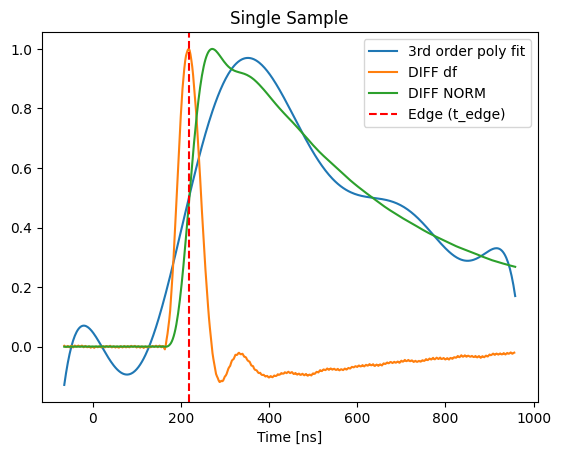

In [9]:
import matplotlib.pyplot as plt
tt = np.arange(-pretrig_size*hcf.SIDIG_timebase, postrig_size*hcf.SIDIG_timebase, hcf.SIDIG_timebase)

sigmwof = dataset["sig_mwoff"]*1000
sigmwof -= sigmwof[0]
sigmwon = dataset["sig_mwon"]*1000
sigmwon -= sigmwon[0]
sig_diff = np.abs(sigmwof - sigmwon)

sig_diff_sum = np.sum(sig_diff)

sig_diff_shifted = np.roll(sig_diff, 1)
sig_diff_df =  sig_diff[1:] - sig_diff[:-1]
sig_diff_df /= np.max(sig_diff_df)
t_edge = tt[np.argmax(sig_diff_df)]
sig_diff_norm = sig_diff/np.max(sig_diff)
p = np.poly1d(np.polyfit(tt, sig_diff_norm, 9))
plt.plot(tt, p(tt), label="3rd order poly fit")
# contrast = sig_diff/sigmwon
# plt.plot(tt, sigmwon, label="MW ON")
# plt.plot(tt, sigmwof, label="MW OFF")

# plt.plot(tt, sig_diff_shifted, label="DIFF shifted")

# plt.plot(tt, contrast, label="CONTRAST")

# plt.plot(tt, sig_diff, label="DIFF")
plt.plot(tt[:-1], sig_diff_df, label="DIFF df")
plt.plot(tt, sig_diff_norm, label="DIFF NORM")
plt.axvline(t_edge, color='r', linestyle='--', label="Edge (t_edge)")
plt.xlabel("Time [ns]")
# plt.ylabel("APD level[mV]")
plt.title("Single Sample")
plt.legend()
plt.show()



Fitted Parameters:
A = 1.31
t0 = 195.71
tau_rise = 35.70
tau_decay = 462.78


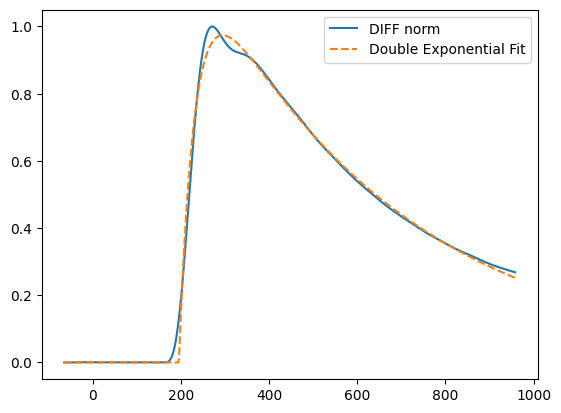

In [10]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def double_exponential(t, A, t0, tau_rise, tau_decay):
    """
    A function describing a pulse with an exponential rise and exponential decay.
    Ensures that tau_decay is greater than tau_rise to produce a positive pulse.
    """
    if tau_rise >= tau_decay:
        return np.inf # Return infinity to guide the fitter away from this invalid parameter space
    
    # Calculate the function only for t > t0, otherwise it's zero
    result = np.zeros_like(t, dtype=float)
    mask = t > t0
    
    term1 = np.exp(-(t[mask] - t0) / tau_decay)
    term2 = np.exp(-(t[mask] - t0) / tau_rise)
    
    result[mask] = A * (term1 - term2)
    return result
# --- Assume tt and sig_diff are your data arrays ---

# New initial guess: [Amplitude, Pulse Start Time, Rise Constant, Decay Constant]
# A good guess for tau_rise is a small number reflecting the fast rise.
# A good guess for A is now larger than the peak, since the function peak is A * (some fraction).
initial_guess = [np.max(sig_diff_norm) * 3, t_edge, 15, 500] 

# Perform the fit with the new function
# You may need to add bounds to ensure tau_decay > tau_rise
popt, _ = curve_fit(
    double_exponential, 
    tt, 
    sig_diff_norm, 
    p0=initial_guess,
    bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]) # Example bounds
)

# Extract fitted parameters
A_fit, t0_fit, tau_rise_fit, tau_decay_fit = popt

print(f"Fitted Parameters:")
print(f"A = {A_fit:.2f}")
print(f"t0 = {t0_fit:.2f}")
print(f"tau_rise = {tau_rise_fit:.2f}")
print(f"tau_decay = {tau_decay_fit:.2f}")

# Generate fitted curve
sig_diff_fit = double_exponential(tt, A_fit, t0_fit, tau_rise_fit, tau_decay_fit)

# Plot fitted curve
plt.plot(tt, sig_diff_norm, label="DIFF norm")
plt.plot(tt, sig_diff_fit, label="Double Exponential Fit", linestyle="--")
plt.legend()
plt.show()

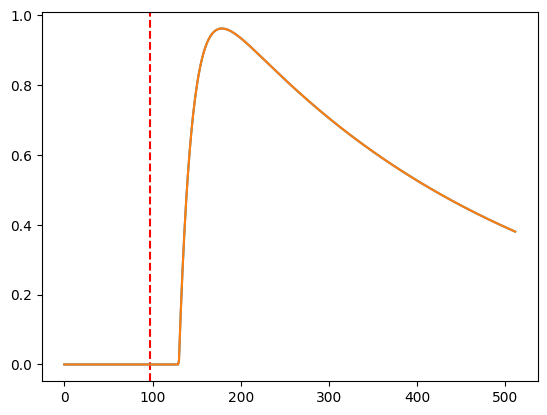

In [11]:
PLINT_WEIGTHT_FITPARA = dict(A = 1.16, t0 = 195.69, tau_rise = 29.75, tau_decay = 683.73)
T0_HEAVISIDE = PLINT_WEIGTHT_FITPARA["t0"]
def plint_weight(t):
    return double_exponential(t, **PLINT_WEIGTHT_FITPARA)
dt = hcf.SIDIG_timebase
WEIGHT_FUNC_DEFAULT = lambda idx: plint_weight(hcf.SIDIG_timebase*(np.array(idx)-PRETRIG_SIZE))

signal_weight_fn = WEIGHT_FUNC_DEFAULT
plintw = plint_weight(tt)
iii = range(SEGMENT_SIZE)
sss = signal_weight_fn(iii)
plt.axvline(int(PLINT_WEIGTHT_FITPARA["t0"] /dt), color='r', linestyle='--', label="Edge (t_edge)")
plt.plot(plintw)
plt.plot(sss)
plt.show()